# Show usage of CaltechDATA

In [1]:
#Get metadata from CaltechDATA

import os
from ames.harvesters import get_caltechdata

if os.path.isdir('data') == False:
    os.mkdir('data')
os.chdir('data')

production = True
collection = 'caltechdata.ds'

get_caltechdata(collection,production)

100% (1741 of 1741) |####################| Elapsed Time: 0:00:03 Time:  0:00:03


level_2  dates
dates dates                     
2019  4               API    793
      4      Deposit Form     80
      4            GitHub    139

level_2  dates
dates dates                     
2021  4               API   1038
      4      Deposit Form    376
      4            GitHub    316

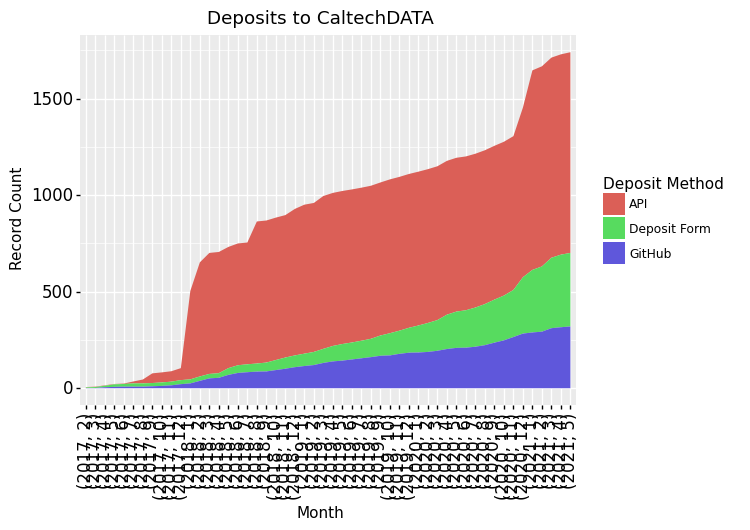

In [9]:
#Collect submissions over time
%matplotlib inline
from ames.harvesters import get_records
from py_dataset import dataset
import pandas as pd
import numpy as np
import plotnine as p9
import warnings
#Plotnine has warning - ignore
#These will hopefully be fixed in future (v0.6?) plotnine release 
warnings.filterwarnings('ignore')

dot_paths = ['._Key','.dates','.resourceType','.subjects','.publicationYear','.contributors']
keys = dataset.keys(collection)
all_metadata = get_records(dot_paths,'dois',collection,keys)
dates = []
categories = []
keys = []
for record in all_metadata:
    #Submitted date type takes precedence, then Updated date (old geo theses), then Issued
    rdate = None
    submitted = None
    issued = None
    for date in record['dates']:
        if date['dateType']=='Submitted':
            rdate = date['date']
        if date['dateType']=='Updated':
            submitted = date['date']
        if date['dateType']=='Issued':
            issued = date['date']
    if rdate == None:
        if submitted != None:
            rdate = submitted
        else:
            rdate = issued
    dates.append(rdate)
    #We categorize records based on submission type
    category = 'Deposit Form'
    thesis = False
    if 'subjects' in record:
        for s in record['subjects']:
            if 'TCCON' in s['subject']:
                category = 'API'
            if 'Bitbucket' in s['subject']:
                category = 'API'
            if 'Atlas of Bacterial and Archaeal Cell Structure' in s['subject']:
                category = 'API'
            if 'Github' in s['subject']:
                category = 'GitHub'
            if 'GitHub' in s['subject']:
                category = 'GitHub'
            if 'thesis' in s['subject']:
                thesis=True
    #Check if Tony handled the thesis record
    if thesis == True:
        if 'contributors' in record:
            for c in record['contributors']:
                if c['contributorName'] == 'Diaz, Tony':
                    category = 'API'
    categories.append(category)
    keys.append(record['_Key'])
data = {'dates':dates,'categories':categories,'keys':keys}
df = pd.DataFrame(data=data)
pd.options.display.max_rows = 2000
df = df.astype({'dates':'datetime64'})
#display(df.sort_values('dates'))
#Group by year, month, and category
df = df.groupby([df["dates"].dt.year, df["dates"].dt.month,df['categories']])['dates'].count()
#Fill in categories with 0 if no values that month
df = df.reindex(pd.MultiIndex.from_product([df.index.levels[0],df.index.levels[1],['API','Deposit Form','GitHub']]),fill_value=0)
#Calculate cumulative sum of categories
df = df.groupby(level=2).cumsum()
#Pull out categories
df = df.reset_index(level=2)
#display(df)
#Cut out future dates with no changes
df = df.loc[(2017,2):(2021,5)]
display(df.loc[(2019,4)])
display(df.loc[(2021,4)])

theme = p9.theme(axis_text_x = p9.element_text(color="black", size=12,
                                                         angle=90),
                           axis_text_y = p9.element_text(color="black", size=12))

plot = p9.ggplot(df, p9.aes(x='dates.index',y='dates',group='level_2',fill='level_2')) + p9.geom_area() + theme + p9.labs(x= 'Month',y= 'Record Count',fill='Deposit Method',title="Deposits to CaltechDATA")
plot.draw()
plot.save('data_plot.png')

In [3]:
#Look at quality of user-submitted records
%matplotlib inline
from ames.harvesters import get_records
from py_dataset import dataset
import pandas as pd
import numpy as np

dot_paths = ['._Key','.dates','.resourceType','.subjects','.publicationYear','.contributors','.descriptions','.electronic_location_and_access']
keys = dataset.keys(collection)
all_metadata = get_records(dot_paths,'dois',collection,keys)
deposit_records = 0
text_files = 0
description_length = 0
text_lengths = []
file_sizes = []
record_sizes = []
for record in all_metadata:
    #We categorize records based on submission type
    category = 'Deposit Form'
    thesis = False
    if 'subjects' in record:
        for s in record['subjects']:
            if 'TCCON' in s['subject']:
                category = 'API'
            if 'Bitbucket' in s['subject']:
                category = 'API'
            if 'Atlas of Bacterial and Archaeal Cell Structure' in s['subject']:
                category = 'API'
            if 'Github' in s['subject']:
                category = 'GitHub'
            if 'GitHub' in s['subject']:
                category = 'GitHub'
            if 'thesis' in s['subject']:
                thesis=True
    #Check if Tony handled the thesis record
    if thesis == True:
        if 'contributors' in record:
            for c in record['contributors']:
                if c['contributorName'] == 'Diaz, Tony':
                    category = 'API'
    if category == 'Deposit Form':
        deposit_records += 1
        record_text_length = 0
        t_file = False
        for description in record['descriptions']:
            #Filter out automated descriptions
            text = description['description']
            if 'Download Citation' not in text:
                if 'Unique Views' not in text:
                    description_length += len(text.split())
                    record_text_length += len(text.split())
        if 'electronic_location_and_access' in record:
            record_size = 0
            for record in record['electronic_location_and_access']:
                name = record['electronic_name'][0]
                if 'txt' in name:
                    t_file = True
                if 'pdf' in name:
                    t_file = True
                size = int(record['file_size'])
                file_sizes.append(size)
                record_size += size
        record_sizes.append(record_size)
        if t_file:
            text_files += 1
        text_lengths.append(record_text_length)
print(f'Deposit records: {deposit_records}')
print(f'Average description length: {description_length/deposit_records}')
print(f'Records with text or pdf: {text_files}')



Deposit records: 381
Average description length: 62.971128608923884
Records with text or pdf: 54


       text_length
count   381.000000
mean     62.971129
std     103.246800
min       1.000000
25%      13.000000
50%      30.000000
75%      72.000000
max     968.000000


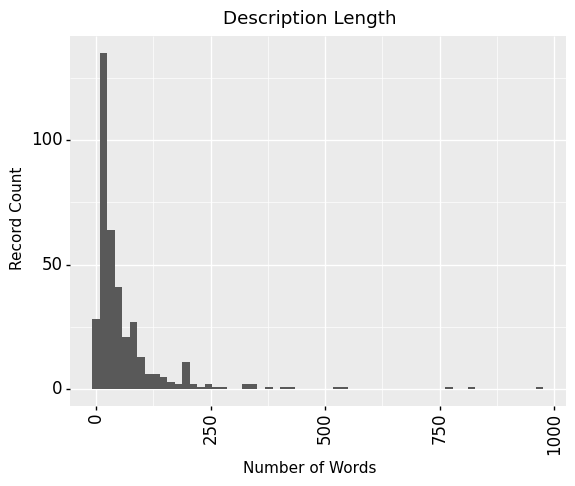

<ggplot: (8763432543690)>

In [4]:
df = pd.DataFrame(data={'text_length':text_lengths})
print(df.describe())
theme = p9.theme(axis_text_x = p9.element_text(color="black", size=12,
                                                         angle=90),
                           axis_text_y = p9.element_text(color="black", size=12))

p9.ggplot(df, p9.aes(x='text_length')) + p9.geom_histogram() + theme + p9.labs(x='Number of Words',y= 'Record Count',title="Description Length")


In [5]:
file_sizes = []
record_sizes = []
total_storage = 0
for record in all_metadata:
        if 'electronic_location_and_access' in record:
            record_size = 0
            for record in record['electronic_location_and_access']:
                name = record['electronic_name'][0]
                if 'txt' in name:
                    t_file = True
                if 'pdf' in name:
                    t_file = True
                size = int(record['file_size'])
                file_sizes.append(size)
                record_size += size
                total_storage += size
            record_sizes.append(record_size)
            if t_file:
                text_files += 1
            text_lengths.append(record_text_length)
print(f'Total Storage (TB): {total_storage/(10**12)}')
print(f'Average storage per record (GB): {total_storage/len(all_metadata)//(10**9)}')


df2 = pd.DataFrame(data={'file_size':file_sizes})
df2 = df2['file_size']/1000000000 #Convert to GB
print(df2.describe())
df3 = pd.DataFrame(data={'record_size':record_sizes})
#df3 = df3['record_size']/1000000000 #Convert to GB
print(df3.describe())
#p9.ggplot(df3, p9.aes(x='record_size'))  + p9.geom_histogram()

Total Storage (TB): 4.559437923216
Average storage per record (GB): 2.0
count    4.204000e+03
mean     1.084548e+00
std      5.452369e+00
min      3.600000e-08
25%      3.416603e-04
50%      4.668790e-03
75%      5.307093e-02
max      1.595936e+02
Name: file_size, dtype: float64
        record_size
count  1.736000e+03
mean   2.626404e+09
std    3.176836e+10
min    6.400000e+01
25%    1.210714e+06
50%    1.296232e+07
75%    5.499942e+07
max    1.063217e+12


In [6]:
#Determine numbers of unique users who have submitted records and what percentage of Caltech campus has used CaltechDATA
dot_paths = ['._Key','.dates','.owners']
keys = dataset.keys(collection)
metadata = get_records(dot_paths,'dois',collection,keys)
dates = []
owners = []
keys = []
for record in metadata:
    #Submitted date type takes precedence, then Updated date (old geo theses), then Issued
    rdate = None
    submitted = None
    issued = None
    for date in record['dates']:
        if date['dateType']=='Submitted':
            rdate = date['date']
        if date['dateType']=='Updated':
            submitted = date['date']
        if date['dateType']=='Issued':
            issued = date['date']
    if rdate == None:
        if submitted != None:
            rdate = submitted
        else:
            rdate = issued
    dates.append(rdate)
    keys.append(record['_Key'])
    if 'owners' in record:
        owners.append(record['owners'][0])
    else:
        owners.append(0)
        #print(record['_Key'])
data = {'dates':dates,'owners':owners,'keys':keys}    
df = pd.DataFrame(data=data)
pd.options.display.max_rows = 2000
df = df.astype({'dates':'datetime64'})
#df = df.query('20180801 < dates < 20190701')
#display(df.sort_values('dates'))
print('Unique users: ',df['owners'].nunique())
#Caltech FTE from https://www.scelc.org/institutions/california-institute-technology
print('Percentage of campus: ',100*df['owners'].nunique()/4200)

Unique users:  163
Percentage of campus:  3.880952380952381


In [7]:
#Determine number of authors per record
dot_paths = ['._Key','.relatedIdentifiers','.creators','.subjects']
keys = dataset.keys(collection)
metadata = get_records(dot_paths,'dois',collection,keys)
num_records = len(metadata)
total_authors = 0
has_paper = 0
automated_software = 0
tccon = 0
thesis = 0
cell_atlas = 0
for record in metadata:
    total_authors += len(record['creators'])
    if 'relatedIdentifiers' in record:
        rel = False
        for identifier in record['relatedIdentifiers']:
            if identifier['relationType'] == 'IsSupplementTo':
                rel = True 
        if rel:
            has_paper += 1
    if 'subjects' in record:
        for s in record['subjects']:
            if 'TCCON' in s['subject']:
                tccon += 1
            if 'Bitbucket' in s['subject']:
                automated_software +=1
            if 'Atlas of Bacterial and Archaeal Cell Structure' in s['subject']:
                cell_atlas += 1
            if 'Github' in s['subject']:
                automated_software +=1
            if 'GitHub' in s['subject']:
                automated_software +=1
            if 'thesis' in s['subject']:
                thesis+=1
print(f'Large record categories {thesis} Theses Records {automated_software} Software Integrations {tccon} TCCON {cell_atlas} Cell Atlas')
print(f'Total number of authors (incl duplicates): {total_authors}')
print(f'Number of records with publication in metadata: {has_paper}')
print(f'Average authors per record: {total_authors/num_records}')

Large record categories 810 Theses Records 386 Software Integrations 74 TCCON 160 Cell Atlas
Total number of authors (incl duplicates): 2875
Number of records with publication in metadata: 1040
Average authors per record: 1.6513497989661114


In [8]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

tdict = {}
text = ''
for record in all_metadata:
    if record['resourceType']['resourceTypeGeneral']=='Dataset':
        keep=True
        for s in record['subjects']:
            if 'TCCON' in s['subject']:
                keep=False
        if keep==True:
            for s in record['subjects']:
                subject = s['subject']
                text = text + ' ' + subject
                if subject in tdict:
                    tdict[subject] +=1
                else:
                    tdict[subject] = 1

print(sorted(tdict.items(), key=lambda kv: kv[1]))
wordcloud = WordCloud(min_font_size=10, max_words=100, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

ModuleNotFoundError: No module named 'wordcloud'